## Student Name:

---

# Tutorial 2 - Part I: probabilistic computations

All the parts that require action (either in the code or equations) are flagged by `<your turn>` or $\color{red}{<your~turn>}$

In [2]:
import numpy as np
import scipy.stats as st
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import matplotlib.pylab as plt

sns.set_style("darkgrid")
sns.set_context("talk")
sns.color_palette("hls", 8)

# Setting matplotlib fonts
from matplotlib import rc
font = {'family': 'serif',
        'weight': 'bold',
        'size': '14'}
rc('font', **font)


# Below is a set of colors for matplotlib that is colorblind-friendly
# To use them in plotting commands, you can simply set "color=colorset[N]",
# where N is an integer in [0,16), reflecting the index of the colors below.
colorset = ['#000000','#00270C','#00443C','#005083',
            '#034BCA','#483CFC','#9C2BFF','#EB24F4',
            '#FF2DC2','#FF4986','#FF7356','#FFA443',
            '#EBD155','#D3F187','#D7FFC8','#FFFFFF']

## Motivation: Algebra of random variables and probabilistic computation

When dealing with algebra of random variables, we are no longer *just* interested in a single value, but also what their distribution dictates on the results. For example:

If X and Y are two random variables with distributions $p_X(X)$ and $p_Y(Y)$, we might be interested in $Z = X+Y$ which itself is a random variable.

For example, if

$$ X\sim \textrm{Normal}(\mu_X,\sigma_X) $$
$$ Y\sim \textrm{Normal}(\mu_Y,\sigma_Y) $$

and if $X$ and $Y$ are independent, then, one can show that

$$ Z \sim \textrm{Normal}(\mu_X+\mu_Y,\sqrt{\sigma_X^2 + \sigma_Y^2})$$

You might recall this is similar to error propagation (in fact it is the underlying algebra of it). While analytical proofs are the ultimate goal and the ideal solution, they are not always practical, so an alternative approach is to approximate a distribution through sampling.

### Monte Carlo simulation for random variable algebra
Assume $X\sim \textrm{Normal}(\mu_X=5,\sigma_X=3) $ and $Y\sim \textrm{Normal}(\mu_Y=15,\sigma_Y=5)$. We define $Z=X+Y$.

#### Exercise - part a: Using tools available in `scipy.stats` (e.g., see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm)), perform Monte Carlo sampling from the distribution of $Z$.

In [3]:
# <your turn>
MC_sample_size = 5000

X_sample = st.norm(loc=5, scale=3).rvs(MC_sample_size)
Y_sample = st.norm(loc=15, scale=5).rvs(MC_sample_size)
Z_sample = X_sample + Y_sample

print('Type of Z_sample:\n', type(Z_sample))
print('Shape of Z_sample:\n', Z_sample.shape)
print('A glimpse of Z_sample:\n',Z_sample)

Type of Z_sample:
 <class 'numpy.ndarray'>
Shape of Z_sample:
 (5000,)
A glimpse of Z_sample:
 [11.29554181 17.40732778 27.16292059 ... 30.57775907 19.94481344
 23.00660308]


#### Exercise - part b: Make a histogram of the resulting MC sample of $Z$.

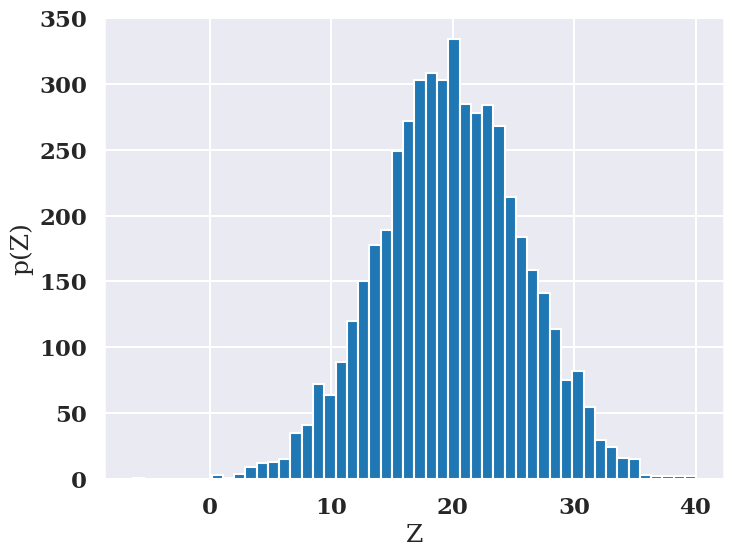

In [4]:
# <your turn>
# Output should be a single plot

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
# <your turn>

ax.hist(Z_sample, bins=50)

# Plot cosmetics
ax.set_xlabel('Z')
ax.set_ylabel('p(Z)');

#### Exercise - part c: Generate a curve representing $p(Z)$ based on the analytical form discussed in the earlier dicussion. Plot this analytical form on top of the histogram from part b and compare.

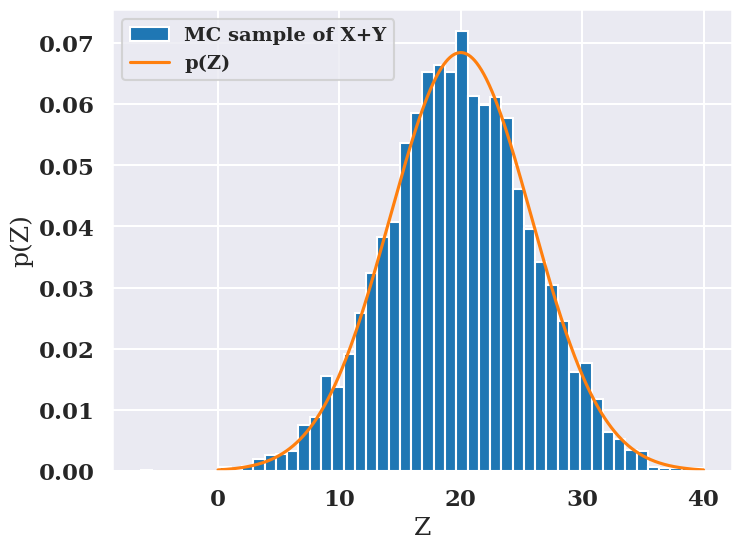

In [5]:
# <your turn>
# Output should be a single plot

theoretical_Z = np.linspace(0, 40, 1000)
theoretical_pZ = st.norm(loc=20,scale=np.sqrt(3**2+5**2)).pdf(theoretical_Z)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
# <your turn>

ax.hist(Z_sample,density=True, bins=50, label='MC sample of X+Y')
ax.plot(theoretical_Z,theoretical_pZ, label='p(Z)')
ax.legend(loc=2,fontsize=14)
# Plot cosmetics
ax.set_xlabel('Z')
ax.set_ylabel('p(Z)');

Broadly speaking, in this workshop we are interested in a more generalized numerical method to calculate distribution of variables like $Z$ as a gateway to our probabilistic inference.

## Probabilistic computations and probabilistic languages

Naively, a probabilistic computer language is a language that allows definition of random variables and performing of algebraic operations on such variables, to enable probabilistic computation. What we did using `scipy.stats` was a simple version of what a probabilistic language can help us with. However, our apprach with `scipy.stats` starts to unravel if we are dealing with ill-normalized distributions (remember the problem with model evidence and normalization of posterior probability density?).

So, let's perform a similar task as we did above, but in a probabilistic language. We will use a probabilistic language built in Python called [PyMC](https://www.pymc.io/welcome.html).

### First steps in PYMC
We define the following random variables:

$$ X \sim \rm{Normal}(\mu=5,\sigma=2) $$
$$ Y \sim \rm{Laplace(\mu=2,b=1)}$$

We define $Z= XY$, and we are interested in its probability distribution.

#### Exercise - part a: Have a look at how PYMC [defines random variable](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-specification) and how it parameterizes a [Laplace distribution](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Laplace.html) and define random variables $X,Y,Z$ based on the distributions above.

In [6]:
# <your turn>
# This cell has no output

with pm.Model() as my_first_model:
    X = pm.Normal('X',mu=5, sigma=2)
    Y = pm.Laplace('Y',mu=2, b=1)
    Z = pm.Deterministic('Z', X*Y)

#### Exercise - part b: Print and explore the computational "type" of your defined variables.

In [7]:
# <your turn>
X

X

In [8]:
type(X)

pytensor.tensor.variable.TensorVariable

#### Exercise - part c: Perform MC sampling for all three variables. Have a look at `pm.sample` [documentation](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html).

In [11]:
# <your turn>
# This cell will print outputs automatically about sampling progression

with my_first_model:
    mc_sample = pm.sample(draws=MC_sample_size)

Output()

We will explore the computational details of the output above shortly, but for now, let's treat it a little superficially:

#### Exercise - part d: Explore the output of sampling. Hint: have a look at documentation of [inference data](https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html).

In [12]:
# <your turn>

mc_sample

Inference data with groups:
	> posterior
	> sample_stats

In [13]:
mc_sample.posterior['X'].to_numpy()

array([[6.76042031, 4.51915775, 4.51915775, ..., 5.76921691, 6.79664067,
        7.40697988],
       [4.98909956, 5.08593924, 6.06774738, ..., 8.02411704, 4.05490555,
        2.34821952]])

### Inspecting MC (and MCMC) outputs efficiently

PYMC ecosystem provides a lot of effective tools to explore our inference and outputs. Here we will use [Arviz](https://python.arviz.org/en/latest/index.html) to visuaize our reuslts.

#### Exercise - part a: Have a look at the documentation of [`plot_density`](https://python.arviz.org/en/latest/api/generated/arviz.plot_density.html#arviz.plot_density) (an example [here](https://python.arviz.org/en/latest/examples/plot_density_single.html)) in Arviz and plot the results of our sampling using that. Explore how $Z$ looks based on the original premise of our "model" ($Z=XY$).

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Z'}>]], dtype=object)

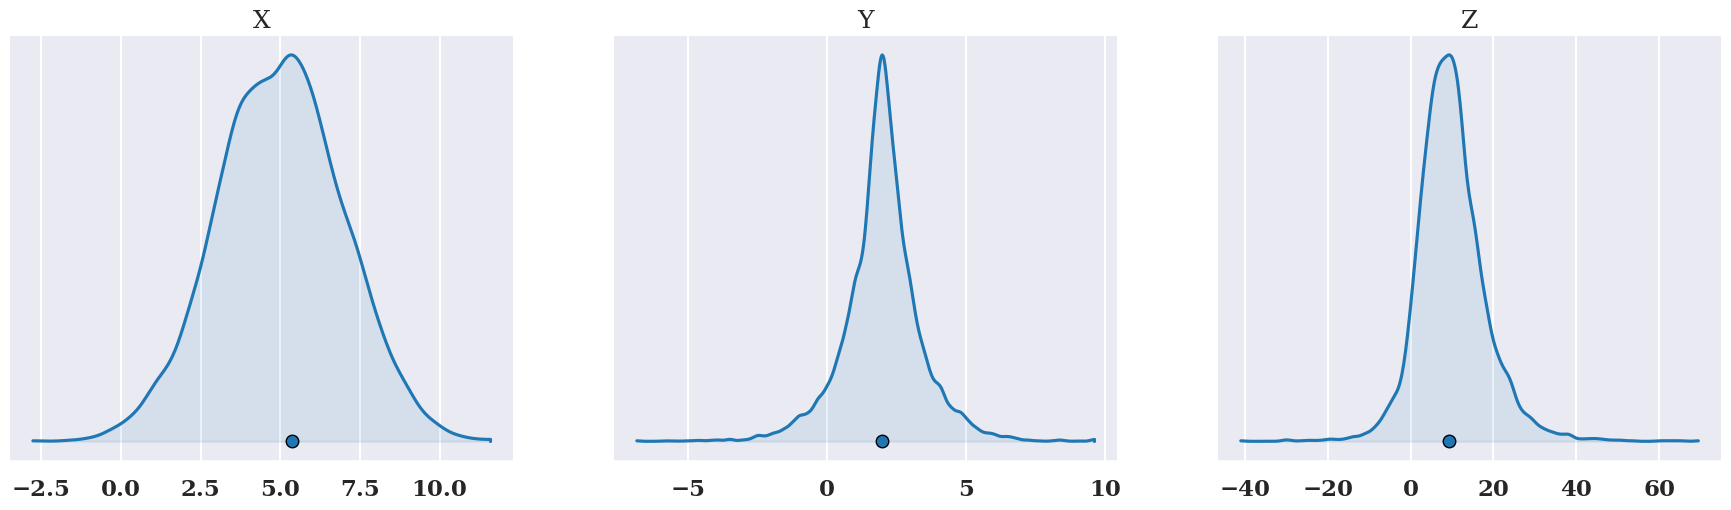

In [14]:
# <your turn>

az.plot_density(mc_sample,point_estimate='mode',hdi_prob=1,shade=0.1)

#### Exercise - part b: Have a look at the documentation of [`plot_pair`](https://python.arviz.org/en/latest/api/generated/arviz.plot_pair.html#arviz.plot_pair) (an example [here](https://python.arviz.org/en/latest/examples/plot_pair_point_estimate.html)) in Arviz and plot the results of our sampling using that. Explore what the plot represents regarding joint and marginal distributions.

array([[<Axes: ylabel='X'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='Y'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='X', ylabel='Z'>, <Axes: xlabel='Y'>,
        <Axes: xlabel='Z'>]], dtype=object)

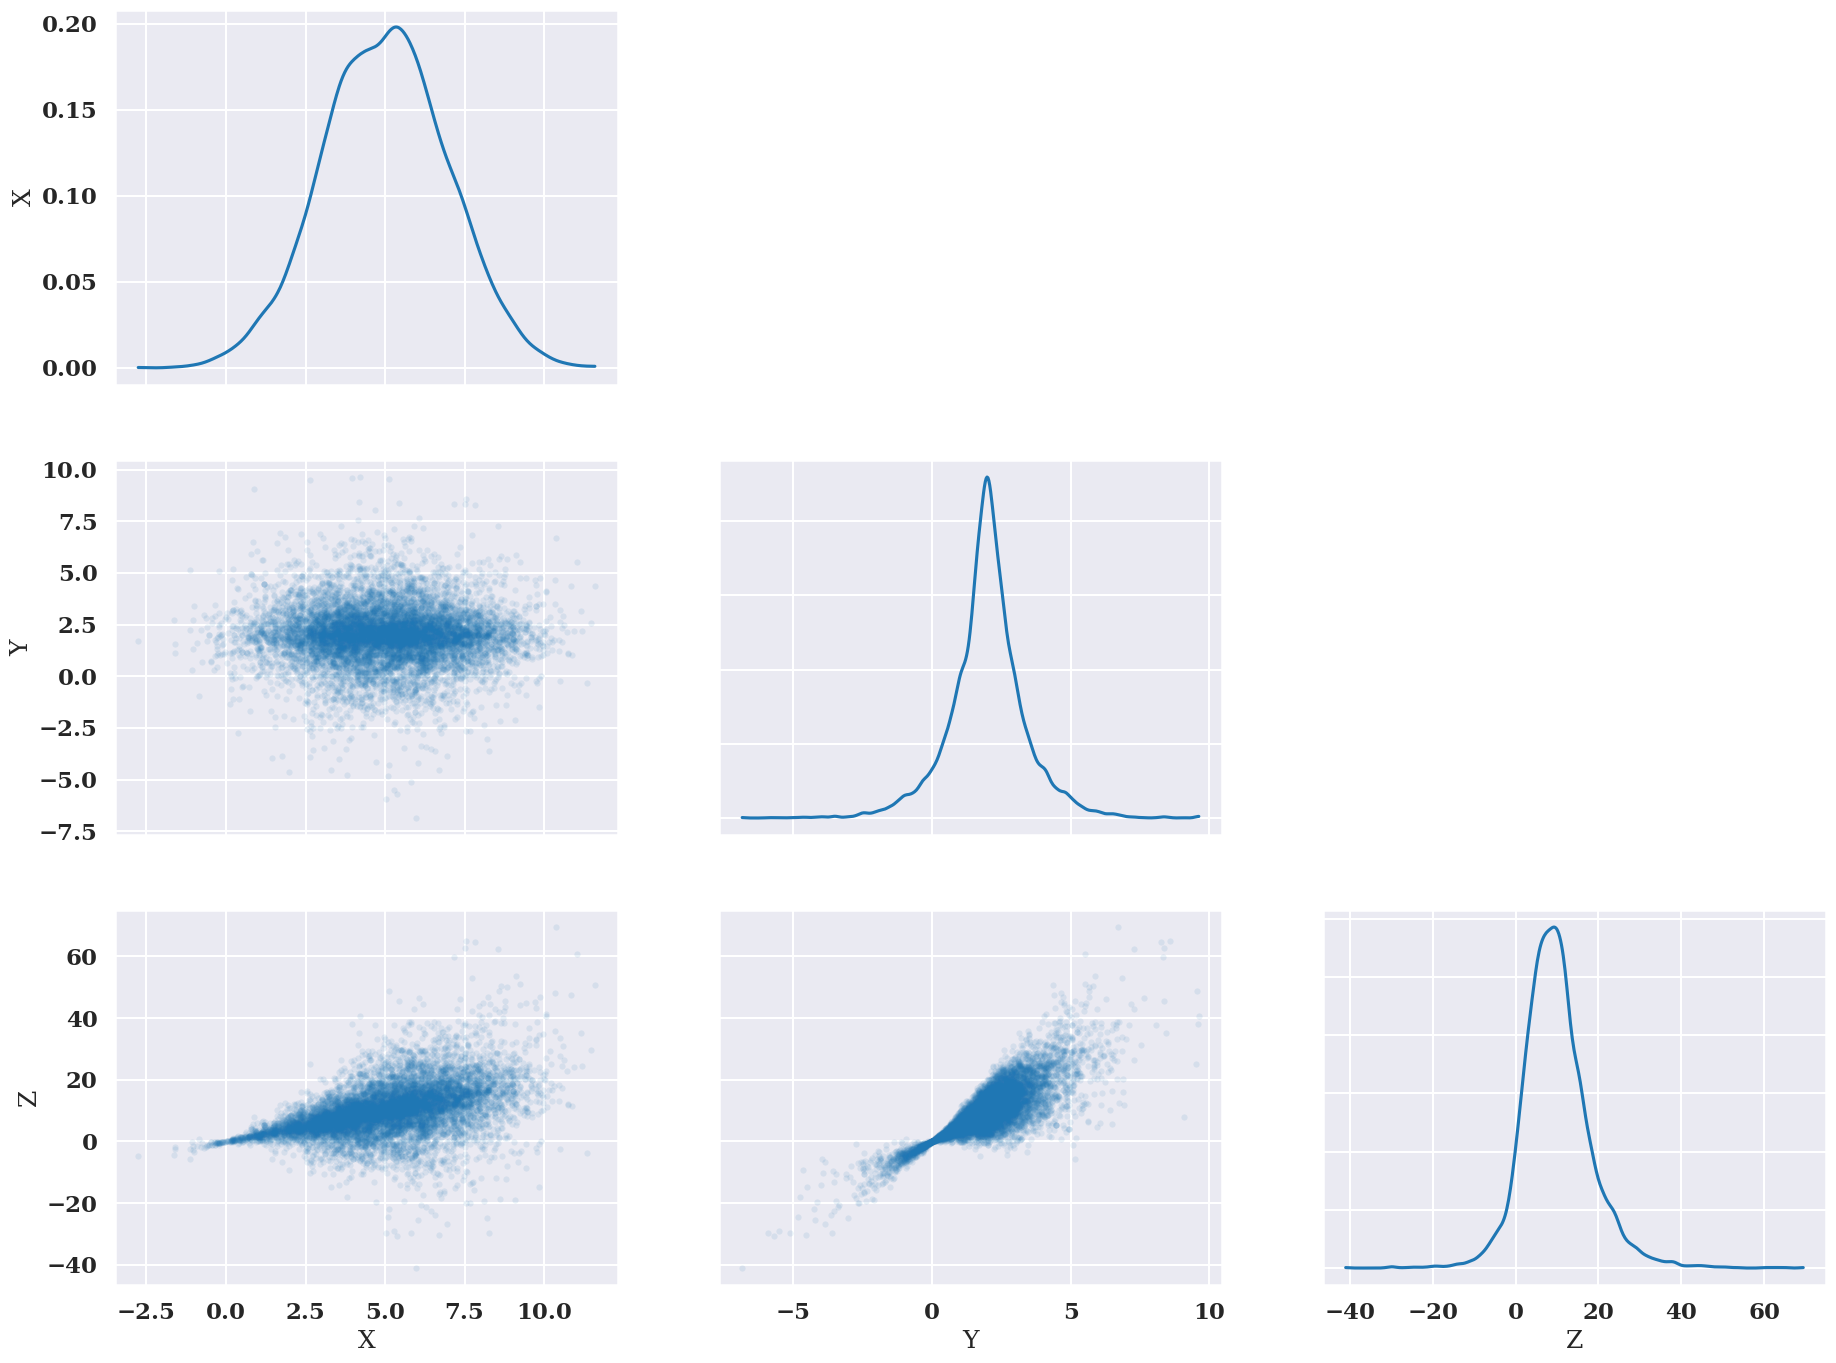

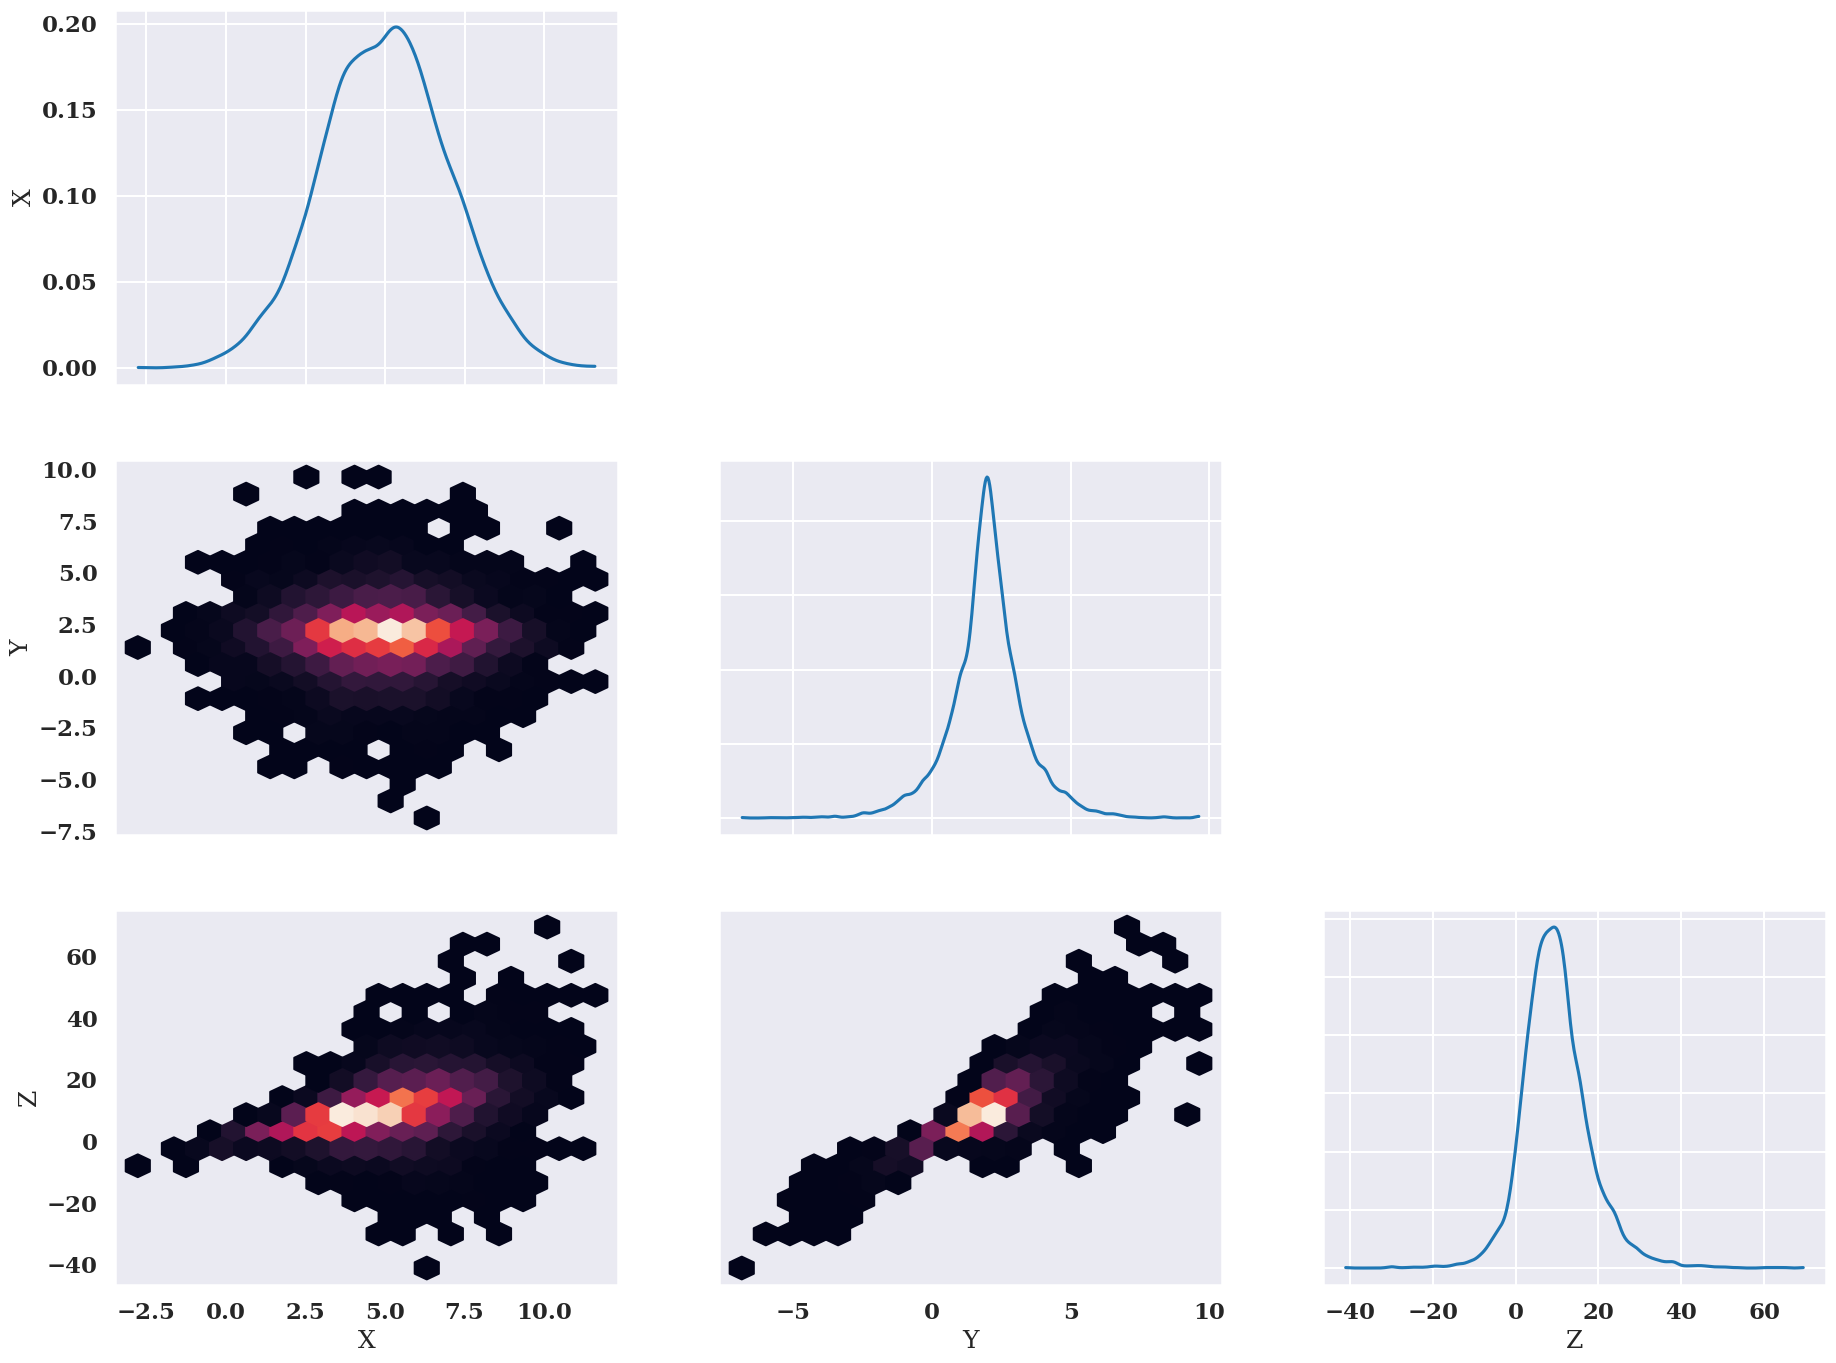

In [15]:
# <your turn>

az.plot_pair(mc_sample, scatter_kwargs={'alpha':0.1}, kind='scatter',marginals=True)
az.plot_pair(mc_sample, kind='hexbin',marginals=True)

### Another quick but perhaps counter-intuituve example

We define:

$$ X\sim\textrm{Uniform}(\min=0,\max=5)$$
$$ Z = X^2 $$

#### Exercise: First think about what would $p(Z)$ look like, then sample and visualize to check if you were correct.

Output()

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Z'}>]],
      dtype=object)

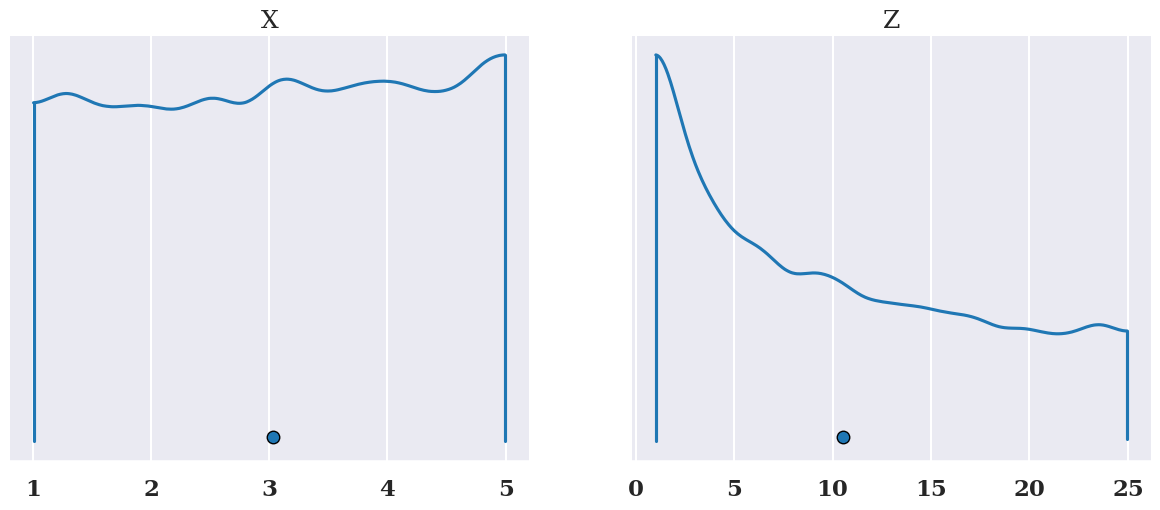

In [16]:
# <your turn>
# Make a model, sample, then plot.

with pm.Model() as my_second_model:
    X = pm.Uniform('X', lower=1, upper=5)
    Z = pm.Deterministic('Z', X**2)
    mc_sample = pm.sample(draws=MC_sample_size)

## Plotting doesn't need to be in the model "context", put it below here.

az.plot_density(mc_sample, hdi_prob=1)

### Hierarchical random variables

In the cases above, we mostly performed simple arithmetic. But random variable algebra can get a bit more complex. For example, imagine we define the following quantities and  **hierarchy**:

$$ \nu_{\rm{H}} \sim \textrm{Lorentz}(\mu_L=10, \sigma_L=1) $$

$$ T \sim \textrm{laplace}(\mu_T = 100, b_T = 10)$$

$$ \nu_{\rm{obs}} \sim \textrm{Normal}(\mu_{\rm{obs}}=\nu_{\rm{H}}, \sigma_{\rm{obs}}=\sqrt{T}) $$

*This is a naive model for the impact of [lifetime broadening](https://en.wikipedia.org/wiki/Spectral_line#Natural_broadening) and [thermal broadening](https://en.wikipedia.org/wiki/Doppler_broadening) on width of spectral lines.*

#### Exercise: Use PyMC to model how these physical effects (random variables) influence each other and plot their density using `plot_density`.

Output()

array([[<Axes: title={'center': 'T'}>, <Axes: title={'center': 'nu_H'}>,
        <Axes: title={'center': 'nu_T'}>]], dtype=object)

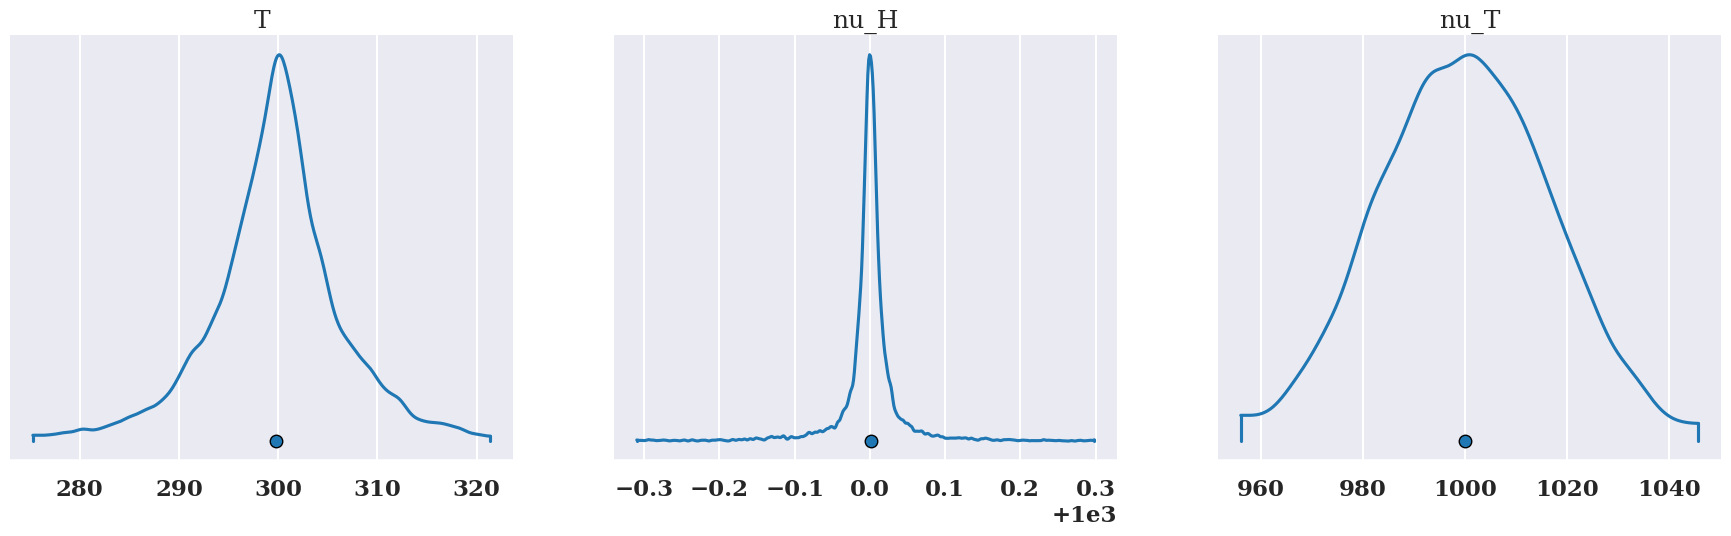

In [17]:
# <your turn>
# Make a model, sample, then plot.

with pm.Model() as my_line_model:
    nu_H = pm.Cauchy('nu_H', alpha=1000, beta=0.01)
    T = pm.Laplace('T', mu=300, b=5)
    nu_T = pm.Normal('nu_T', mu=nu_H, sigma=T**0.5)
    mc_sample = pm.sample(draws=MC_sample_size)

## Plotting doesn't need to be in the model "context", put it below here.

az.plot_density(mc_sample, hdi_prob=0.99)

Assuming a very low temperature:
$$ T\sim \rm{Exponential}(\lambda=100) $$

Output()

ERROR:pymc.stats.convergence:There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'T'}>, <Axes: title={'center': 'nu_H'}>,
        <Axes: title={'center': 'nu_T'}>]], dtype=object)

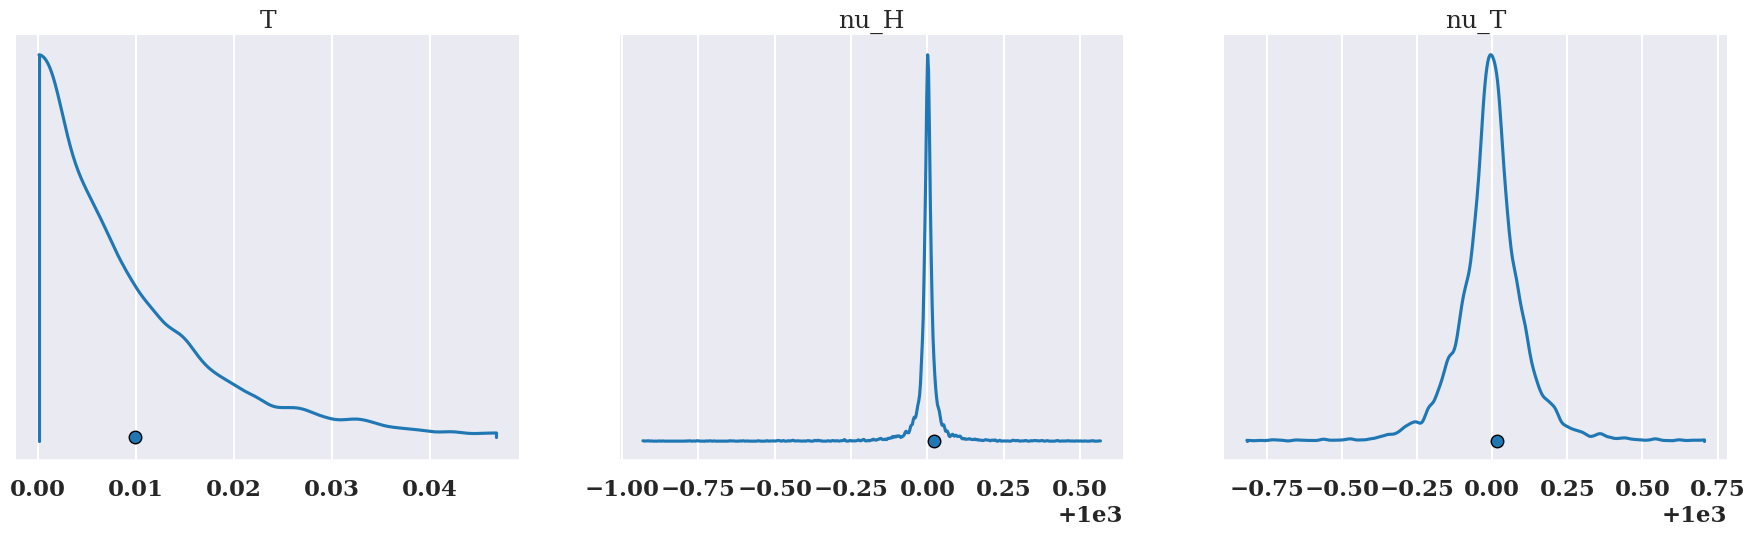

In [18]:
# <your turn>
# Make a model, sample, then plot.

with pm.Model() as my_line_model:
    nu_H = pm.Cauchy('nu_H', alpha=1000, beta=0.01)
    T = pm.Exponential('T', lam=100)
    nu_T = pm.Normal('nu_T', mu=nu_H, sigma=T**0.5)
    mc_sample = pm.sample(draws=MC_sample_size)

## Plotting doesn't need to be in the model "context", put it below here.

az.plot_density(mc_sample, hdi_prob=0.99)

Now let us apply our tools on probabilistic computation to our problems in inference.

## linear regression

Starting with the example in the lecture, we have made $N$ independent measurements of a quantity $Y$ (with each measurement containing normally-distributed uncertainties), at different values of quantity $X$. Assuming $Y$ as a function of $X$, we want to infer a model for the "model" $Y$ (which we label $Y_{\rm{Model}}$), given what we can *observe* as $Y$ ($Y_{\rm{obs}}$).

### Data

Our data consists of three numbers per measurement:

$$ x = [x_1,\cdots,x_N] $$
$$ \hat{y}_{\rm{obs}} = [\hat{y}_1,\cdots,\hat{y}_N] $$
$$ \hat{\sigma} = [\hat{\sigma}_1,\cdots,\hat{\sigma}_N] $$


In this unit we will use [Pandas](https://pandas.pydata.org/) for data operations. Here is [a quick cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) for using Pandas.

In [19]:
DATA = pd.read_csv('https://raw.githubusercontent.com/bersavosh/P4003/refs/heads/main/Tutorials/T2_data.csv')
DATA.head()
DATA.describe()

,x,y_obs,sigma_obs
count,100.000000,100.000000,100.000000
mean,10.229083,61.236394,4.495145
std,3.082873,16.599029,0.451536
min,5.045212,27.912342,3.582608
25%,7.624087,45.996963,4.165048
50%,10.160725,59.082053,4.508802
75%,13.229119,75.569135,4.833199
max,14.930419,93.283712,5.516144


### EDA
#### Exercise: Make a scatter plot the measurements and uncertainties of $\hat{y}_{\rm{obs}}$ as a function of $x$. To do this, you can simply use `plt.errorbar()` in matplotlib.

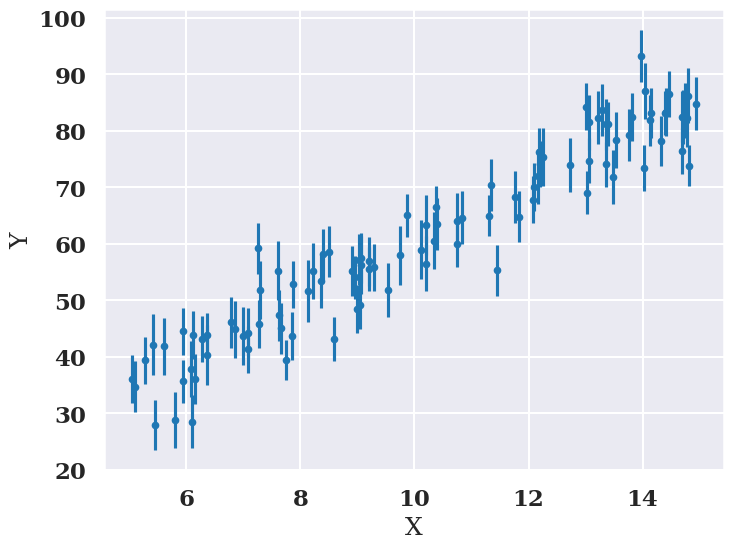

In [21]:
# <your turn>
x = DATA['x'].to_numpy()
y = DATA['y_obs'].to_numpy()
sigma = DATA['sigma_obs'].to_numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
# <your turn>
ax.errorbar(x,y,sigma,fmt='.')


# Plot cosmetics
ax.set_xlabel('X')
ax.set_ylabel('Y');

### Our model

Similar to the lecture, we assume that our understanding of the physics, hypothetically, suggest that
$$ Y_{\rm{Model}}(x; m, d) = m x + d $$

and similar to the lecture we assume the following priors on $m$ and $d$:

$$ m \sim \textrm{Uniform}(\min=0,\max=10) $$
$$ d \sim \textrm{Uniform}(\min=-20,\max=20) $$

and we define that

$$ \hat{Y}_{\rm{obs}} \sim \textrm{Normal}(Y_{\rm{Model}}(x),\sigma_Y) $$

and we remember that we consider $\hat{y}_{\rm{obs}} = [\hat{y}_1,\cdots,\hat{y}_N]$ as random draws of $\hat{Y}_{\rm{obs}}$.



#### Exercise - part a: Build a PyMC model with the variables above. With the following steps:
 - Start with the data. Data can be defined in a PyMC model using `pm.Data`.
 - Then add the model parameters and variables we have defined above.

In [28]:
# <your turn>
# just define the model and its components, no sampling or plotting needed here.


with pm.Model() as regression_model:
    ## First define your data here:
    x = pm.Data('x',DATA['x'])
    y_obs = pm.Data('y_obs',DATA['y_obs'])
    sigma_obs = pm.Data('sigma_obs',DATA['sigma_obs'])

    ## Now define your model variables
    m = pm.Uniform('m', lower=0, upper=10)
    d = pm.Uniform('d', lower=-20, upper=20)
    Y_model = pm.Deterministic('Y_model', m * x + d)
    Y_obs = pm.Normal('Y_obs', mu=Y_model, sigma=sigma_obs)



# No plotting or sampling needed yet.

#### Exercise - part b: Explore the model structures by making a diagram of model's [plate notation](https://en.wikipedia.org/wiki/Plate_notation). For this purpose, you can use `pm.model_to_graphviz` (see documentation [here](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.model_to_graphviz.html)).

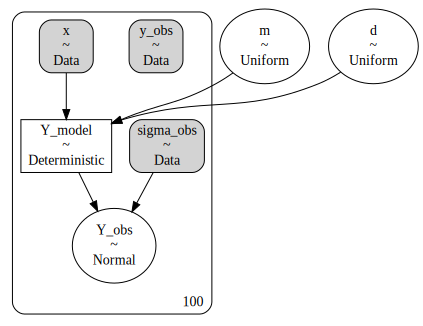

In [29]:
# <your turn>
pm.model_to_graphviz(regression_model)


#### Exercise - part c: Our model has a problem, can you spot it? fix the issue in the cell below and replot the plate notation.
(*hint: where is the link between our data and $\hat{Y}_{\rm{obs}}$ variable?*)

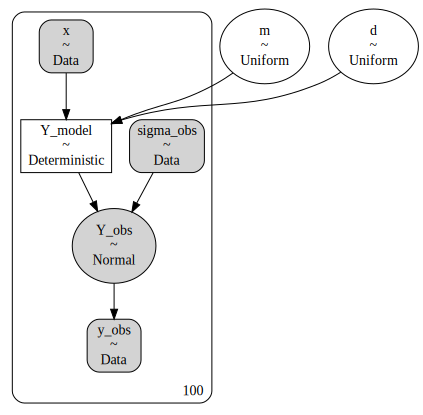

In [37]:
# <your turn>
# just define the model and its components, no sampling or plotting needed here.


with pm.Model() as regression_model:
    ## First define your data here:
    x = pm.Data('x',DATA['x'])
    y_obs = pm.Data('y_obs',DATA['y_obs'])
    sigma_obs = pm.Data('sigma_obs',DATA['sigma_obs'])

    ## Now define your model variables
    m = pm.Uniform('m', lower=0, upper=10)
    d = pm.Uniform('d', lower=-20, upper=20)
    Y_model = pm.Deterministic('Y_model', m * x + d)
    Y_obs = pm.Normal('Y_obs', mu=Y_model, sigma=sigma_obs,observed=y_obs)

pm.model_to_graphviz(regression_model)

# No plotting or sampling needed yet.

In [ ]:
# <your turn>
# redefine the model and replot the model graph

with pm.Model() as regression_model:
    ## First define your data here:

    ## Now define your model variables



# graph visualization can be put under here


### MCMC sampling

Note that we are now actually performing MCMC (and not MC).

#### Exercise - part a: perform sampling with the model we defined above. Run your sampling with `discard_tuned_samples=False`.

In [38]:
# <your turn>

with regression_model:
    regression_mcmc_sample = pm.sample(draws=5000, chains=4, discard_tuned_samples=False)

Output()

#### Exercise - part b: Assess sampling performance. Think about what the sampling progress bar and table show. Print the resulting inference data `regression_mcmc_sample` to explore what is captured.

In [41]:
# <your turn>
regression_mcmc_sample



Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Warmup iterations saved (warmup_*).

#### Exercise - part c: Use `az.plot_trace` to look at how your chains have "walked" (use `var_names=['m','d']` to focus on just these parameters). First do this for `posterior` (the default), then do the same for `warmup_posterior`. Do you notice anything unusual?

array([[<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>]],
      dtype=object)

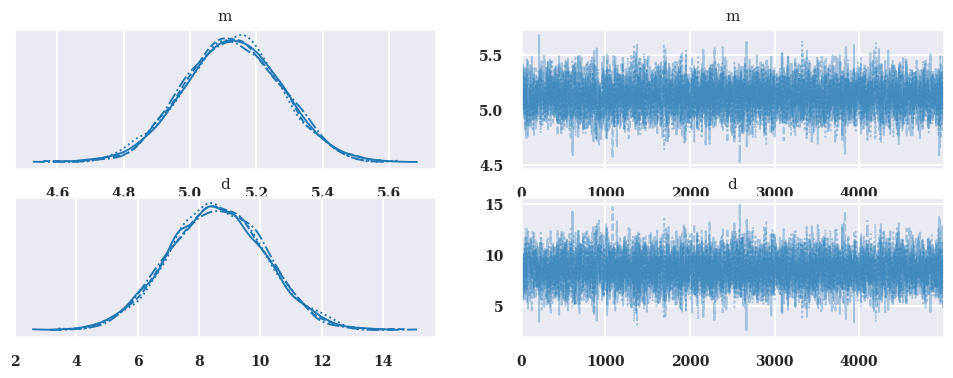

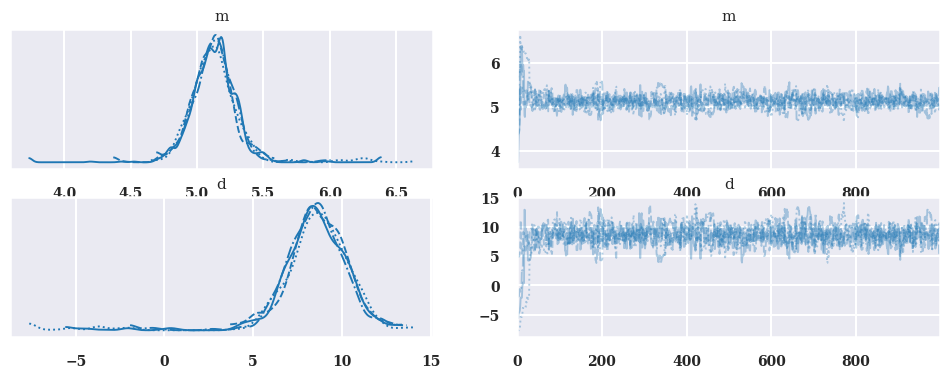

In [45]:
# <your turn>
## output should be two separate figures
az.plot_trace(regression_mcmc_sample,var_names=['m','d'])
az.plot_trace(regression_mcmc_sample.warmup_posterior,var_names=['m','d'])

# on LHS KDE for each chain and RHS 'fuzzy caterpillar' for each walk
# auto correlated random walkers in valley gravity analogy
# Monte Carlo Markov Chain - sampled from distribution without knowing its shape or distribution


### Model fitting results

#### Exercise - part a: Print summary of the posterior with `pm.summary`. Think about what the values in the summary table mean. Use 68% HDI probability for interval estimation.

In [46]:
# <your turn>

# checking for m and d at the same time - Gelman-Rubin statistics

fit_summary = pm.summary(regression_mcmc_sample,var_names=['m','d'])

fit_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,5.127,0.146,4.852,5.397,0.002,0.002,3882.0,3494.0,1.0
d,8.593,1.573,5.715,11.603,0.025,0.020,3887.0,3774.0,1.0


#### Exercise - part b: using plotting functions we have discussed in earlier exercises, plot the marginal posterior samples ("densities") of $m$ and $d$.

array([<Axes: title={'center': 'm'}>, <Axes: title={'center': 'd'}>],
      dtype=object)

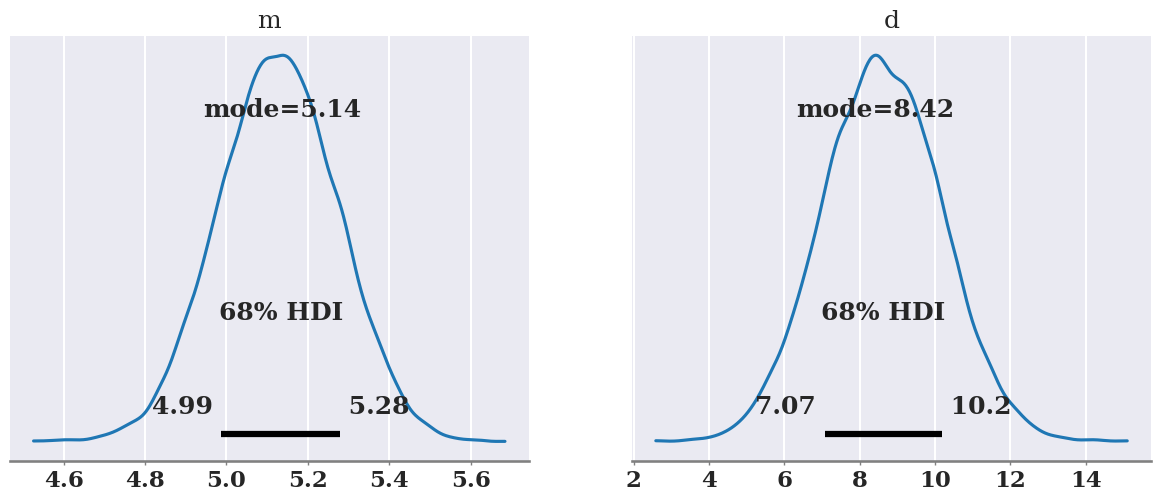

In [49]:
# <your turn>
az.plot_posterior(regression_mcmc_sample,var_names=['m','d'],round_to=3,hdi_prob=0.68,point_estimate='mode')


#### Exercise - part c: using plotting functions we have discussed in earlier exercises, plot the joint and margian posterior samples of $m$ and $d$.

array([[<Axes: >, None],
       [<Axes: xlabel='m', ylabel='d'>, <Axes: >]], dtype=object)

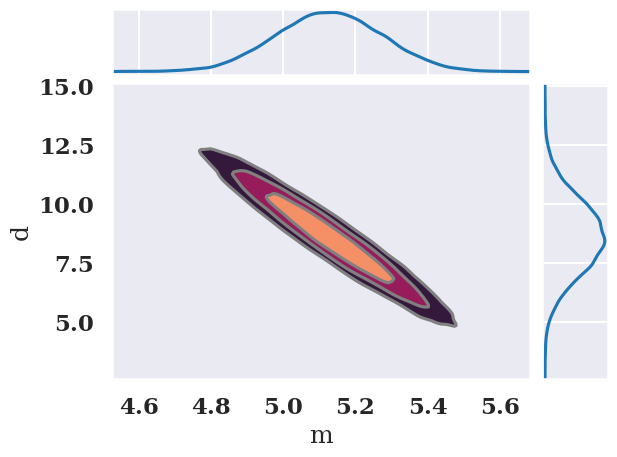

In [52]:
# <your turn>
# corner plot (aka pairwise plot)
# data updates its understanding
# kde contours represent the credible/confidence intervas 68% 95% 99.5% etc
pm.plot_pair(regression_mcmc_sample,var_names=['m','d'],marginals=True,kind='kde')


#### Exercise - part d: Reuse your code from plotting the data, and add a line representing the model with posterior means.
*hint: you can extract the exact values from your inference data `regression_mcmc_sample.posterior['m'].mean().values`.

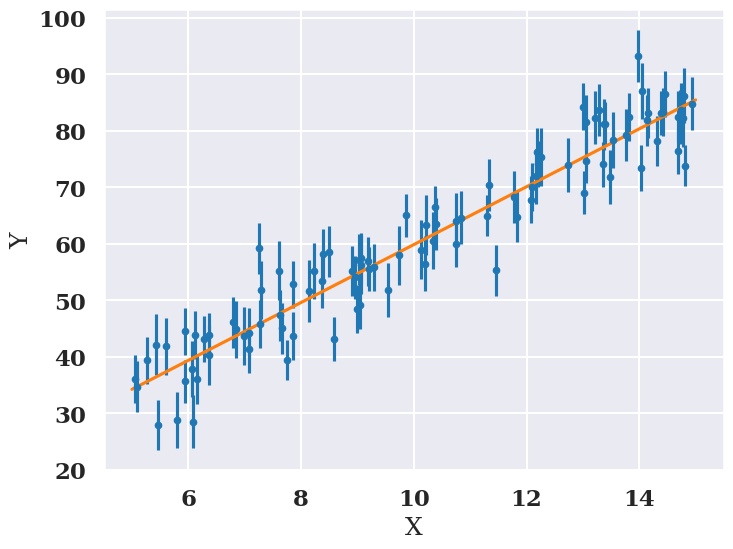

In [55]:
# <your turn>
# higher level languages can be tricky to debug
mean_m = regression_mcmc_sample.posterior['m'].mean().values
mean_d = regression_mcmc_sample.posterior['d'].mean().values
test_x = np.linspace(5,15)
test_y = mean_m * test_x + mean_d

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
# <your turn>
ax.errorbar(DATA['x'],DATA['y_obs'],DATA['sigma_obs'],fmt='.')
ax.plot(test_x,test_y)


# Plot cosmetics
ax.set_xlabel('X')
ax.set_ylabel('Y');

#### Exercise - part e: Reuse your code from plotting above and visualize 99% HDI of $Y_{\rm{model}}$. You can do this using `az.plot_hdi`.

In [ ]:
# <your turn>
# why does the data not fall in the 99 HDI percent

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
# <your turn>



# Plot cosmetics
ax.set_xlabel('X')
ax.set_ylabel('Y');

## You can now save the notebook and download it.